In [32]:
import numpy as np
import pickle
import pandas as pd
import os
from os.path import join
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score
from scipy import stats
import xgboost as xgb

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl
# plt.style.use('CCB_plot_style_0v4.mplstyle')
# c_styles      = mpl.rcParams['axes.prop_cycle'].by_key()['color']   # fetch the defined color styles
# high_contrast = ['#004488', '#DDAA33', '#BB5566', '#000000']

## Loading training and test data:

In [36]:
data_train = pd.read_pickle(join("..", "..", "data", "train_df_kcat_Seed plants.pkl"))
data_test = pd.read_pickle(join("..", "..", "data", "test_df_kcat_Seed plants.pkl"))

# data_train["geomean_kcat"] = np.log10(data_train["geomean_kcat"])
# data_test["geomean_kcat"] = np.log10(data_test["geomean_kcat"])

data_train["log10_kcat"] = np.log10(data_train["kcat"])
data_test["log10_kcat"] = np.log10(data_test["kcat"])

# data_train.rename(columns = {"geomean_kcat" :"log10_kcat"}, inplace = True)
# data_test.rename(columns = {"geomean_kcat" :"log10_kcat"}, inplace = True)

data_train.rename(columns = {"Enzyme rep" : "ESM2"}, inplace = True)
data_test.rename(columns = {"Enzyme rep" : "ESM2"}, inplace = True)

data_train['Temperature'] = data_train['Temperature'].replace('-', np.nan)
data_test['Temperature'] = data_test['Temperature'].replace('-', np.nan)
data_train['pH'] = data_train['pH'].replace('-', np.nan)
data_test['pH'] = data_test['pH'].replace('-', np.nan)
data_train['Type'] = data_train['Type'].replace('wildtype', 1)
data_train['Type'] = data_train['Type'].replace('mutant', 2)
data_test['Type'] = data_test['Type'].replace('wildtype', 1)
data_test['Type'] = data_test['Type'].replace('mutant', 2)

data_train['MACCS FP'] = data_train['MACCS FP'].astype(str)
data_test['MACCS FP'] = data_test['MACCS FP'].astype(str)

len(data_train), len(data_test)

(332, 129)

In [37]:
train_indices = list(np.load(join("..", "..", "data", "CV_train_indices_Seed plants.npy"), allow_pickle = True))
test_indices = list(np.load(join("..", "..", "data", "CV_test_indices_Seed plants.npy"), allow_pickle = True))

## 1. Training a model with enzyme and substrate information (ESM-2/MACCS) + Temperature + pH:

#### (a) Creating input matrices:

In [38]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array([list(s) for s in data_train['MACCS FP']]), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array([list(s) for s in data_test['MACCS FP']]), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [ ]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))


# from hyperopt import fmin, tpe, rand, hp, Trials

# space_gradient_boosting = {
#     "learning_rate": hp.quniform("learning_rate", 0.01, 0.1),
#     "max_depth": hp.quniform("max_depth", 3,10),
#     #"subsample": hp.quniform("subsample", 0.5, 1),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1),
#     "max_delta_step": hp.quniform("max_delta_step", 0, 5),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6),
#     "num_rounds":  hp.quniform("num_rounds", 50, 200)}


# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 200, trials=trials)

In [ ]:
print(best)

{'learning_rate': 0.07735824876879432, 'max_delta_step': 2.3485483591317946, 'max_depth': 3.325598136179658, 'min_child_weight': 4.616388694690552, 'num_rounds': 186.1760335768676, 'reg_alpha': 0.30666063128670695, 'reg_lambda': 0.512000418659313}

#### (c) Training and validating model:

In [39]:
param = {"random_state": 42,
         'learning_rate': 0.07735824876879432,
          'max_delta_step': 2.3485483591317946,
            'max_depth': 3.325598136179658,
              'min_child_weight': 4.616388694690552,
                'num_rounds': 186.1760335768676,
                  'reg_alpha': 0.30666063128670695,
                    'reg_lambda': 0.512000418659313}

num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [6]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", "Pearson_CV_xgboost_ESM1b_ts_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", "MSE_CV_xgboost_ESM1b_ts_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", "R2_CV_xgboost_ESM1b_ts_diff_fp.npy"), np.array(R2))

[0.9845463759403826, -0.0004848528169057872, 0.9649152421319005, 0.6888567261671078, 0.8811177135000052]
[147.1922184772749, 178.71797697863903, 127.42857843129295, 96.3196910764228, 94.30415425188197]
[0.605350530048272, -0.4839426858566156, 0.7538292512256938, 0.4308452414932312, 0.7385761987738038]
[33.819205400608, 64.30403885143288, 38.044356149555014, 31.58758338521389, 42.41136563328476]
[3.005599916139577, 4.60049441511998, 2.747197250165794, 2.132815652769875, 5.699218996272457]


In [40]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))
# MedAE = np.median(abs(np.array(test_Y) - np.array(y_test_pred)))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))

np.save(join("..", "..", "data", "y_test_pred_xgboost_ESM1b_ts_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data",  "y_test_true_xgboost_ESM1b_ts_diff_fp.npy"), test_Y)

0.909 222.276132409 0.573 66.7384904566 5.5638264292


In [ ]:
y_test_pred_esm1b_ts_drfp = y_test_pred

In [31]:
pd.DataFrame(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))).describe()

,0
count,79.000000
mean,49.516000
std,136.449550
min,0.050815
25%,1.308957
50%,4.386824
75%,18.150756
max,755.701837


#### (d) Training model with test and train data for production mode:

In [41]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array([list(s) for s in data_train['MACCS FP']]), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array([list(s) for s in data_test['MACCS FP']]), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [42]:
param = {"random_state": 42, 
         'learning_rate': 0.07735824876879432,
          'max_delta_step': 2.3485483591317946,
            'max_depth': 3.325598136179658,
              'min_child_weight': 4.616388694690552,
                'num_rounds': 186.1760335768676,
                  'reg_alpha': 0.30666063128670695,
                    'reg_lambda': 0.512000418659313}

num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.9807732085629067, 5.427141156172195e-92) 112.46480198260625 0.8907494997054466


In [47]:
data_val = pd.read_pickle(join("..", "..", "data", "validation_Seed plants.pkl"))

data_val["log10_kcat"] = np.log10(data_val["kcat"])

data_val['Temperature'] = data_val['Temperature'].replace('-', np.nan)
data_val['pH'] = data_val['pH'].replace('-', np.nan)
data_val['Type'] = data_val['Type'].replace('wildtype', 1)
data_val['Type'] = data_val['Type'].replace('mutant', 2)

data_val['MACCS FP'] = data_val['MACCS FP'].astype(str)

val_X = np.array(list(data_val["Enzyme rep"]))
val_X = np.concatenate([val_X, np.array([list(s) for s in data_val['MACCS FP']]), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

In [48]:
dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE)

(0.030575291102646937, 0.47103308925992937) 289.97274780361676 -0.08707458966673798 6.7217987501546945


## 2. Training a model with enzyme and reaction information (ESM-2/diff_fp) + Temperature + pH:

#### (a) Creating input matrices:

In [15]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [ ]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))


# from hyperopt import fmin, tpe, rand, hp, Trials

# space_gradient_boosting = {
#     "learning_rate": hp.quniform("learning_rate", 0.01, 0.1),
#     "max_depth": hp.quniform("max_depth", 3,10),
#     #"subsample": hp.quniform("subsample", 0.5, 1),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1),
#     "max_delta_step": hp.quniform("max_delta_step", 0, 5),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6),
#     "num_rounds":  hp.quniform("num_rounds", 50, 200)}


# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 200, trials=trials)

In [ ]:
print(best)

{'learning_rate': 0.05085263944966642, 'max_delta_step': 0.34083074720667517, 'max_depth': 6.6383781871412975, 'min_child_weight': 1.785327413622166, 'num_rounds': 140.07035863793124, 'reg_alpha': 0.6550736652454903, 'reg_lambda': 0.45565291267044783}

#### (c) Training and validating model:

In [16]:
param = {"random_state": 42, 
         'learning_rate': 0.05085263944966642,
          'max_delta_step': 0.34083074720667517, 
          'max_depth': 6.6383781871412975, 
          'min_child_weight': 1.785327413622166, 
          'num_rounds': 140.07035863793124, 
          'reg_alpha': 0.6550736652454903, 
          'reg_lambda': 0.45565291267044783}

num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [17]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", "Pearson_CV_xgboost_ESM1b_ts_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", "MSE_CV_xgboost_ESM1b_ts_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", "R2_CV_xgboost_ESM1b_ts_diff_fp.npy"), np.array(R2))

[0.11284081902887813, 0.5340621231369477, 0.4755031955064507, 0.7068652673378025, 0.6188509293686267]
[349.0132952720351, 186.85987303536453, 225.97437314840468, 372.56826536784877, 232.34606229806676]
[-0.07990420021248701, 0.2519905199898671, 0.16588790351296379, 0.1868011195600915, 0.16690344544999125]
[114.33932620845145, 57.66237542999814, 54.238778624880275, 113.36144619804008, 65.90082100342782]
[8.550208269101368, 7.391696765003017, 2.48715248901702, 6.842005614474944, 2.517018327358105]


In [18]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)
MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))

np.save(join("..", "..", "data", "y_test_pred_xgboost_ESM1b_ts_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data",  "y_test_true_xgboost_ESM1b_ts_diff_fp.npy"), test_Y)

0.699 185.8486985986 0.329 57.6686717522 4.5023387706


In [ ]:
y_test_pred_esm1b_ts_drfp = y_test_pred

#### (d) Training model with test and train data for production mode:

In [ ]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [ ]:
param = {"random_state": 42, 
         'learning_rate': 0.05085263944966642,
          'max_delta_step': 0.34083074720667517, 
          'max_depth': 6.6383781871412975, 
          'min_child_weight': 1.785327413622166, 
          'num_rounds': 140.07035863793124, 
          'reg_alpha': 0.6550736652454903, 
          'reg_lambda': 0.45565291267044783}

num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

## 3. Training a model with enzyme, substrate (MACCS fp) and reaction information (ESM-2/diff_fp) + Temperature + pH:

#### (a) Creating input matrices:

In [10]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array([list(s) for s in data_train['MACCS FP']]), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array([list(s) for s in data_test['MACCS FP']]), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [ ]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))


# from hyperopt import fmin, tpe, rand, hp, Trials

# space_gradient_boosting = {
#     "learning_rate": hp.quniform("learning_rate", 0.01, 0.1),
#     "max_depth": hp.quniform("max_depth", 3,10),
#     #"subsample": hp.quniform("subsample", 0.5, 1),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1),
#     "max_delta_step": hp.quniform("max_delta_step", 0, 5),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6),
#     "num_rounds":  hp.quniform("num_rounds", 50, 200)}


# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 200, trials=trials)

In [ ]:
print(best)

#### (c) Training and validating model:

{'learning_rate': 0.07686690526974309, 'max_delta_step': 2.8106244592348597, 'max_depth': 3.2147784190937037, 'min_child_weight': 2.998958453846422, 'num_rounds': 125.49454227567935, 'reg_alpha': 0.9844061280217642, 'reg_lambda': 0.5220012194459824}

In [11]:
param = {"random_state": 42, 
         'learning_rate': 0.07686690526974309, 
         'max_delta_step': 2.8106244592348597, 
         'max_depth': 3.2147784190937037, 
         'min_child_weight': 2.998958453846422, 
         'num_rounds': 125.49454227567935, 
         'reg_alpha': 0.9844061280217642, 
         'reg_lambda': 0.5220012194459824}

num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [9]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", "Pearson_CV_xgboost_ESM1b_ts_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", "MSE_CV_xgboost_ESM1b_ts_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", "R2_CV_xgboost_ESM1b_ts_diff_fp.npy"), np.array(R2))

[0.1767894839665381, 0.526225481492021, 0.5317107890829348, 0.69458986667742, 0.435259068603419]
[343.95669835047715, 191.01349234638627, 217.2676056955267, 377.3887950044455, 237.28724240860208]
[-0.048839007408948865, 0.2183666285691438, 0.22892611298977672, 0.1656215949501394, 0.13109262446266723]
[108.86179766745366, 58.266389165321115, 50.744241592038826, 112.13847550849171, 65.83688722240174]
[6.403195956114361, 6.23029251985951, 2.02511642746311, 7.275122752269446, 2.8698965992523666]


In [12]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)
MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))

np.save(join("..", "..", "data", "y_test_pred_xgboost_ESM1b_ts_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data",  "y_test_true_xgboost_ESM1b_ts_diff_fp.npy"), test_Y)

0.773 144.4201960317 0.528 47.9901717755 4.2409361532


In [ ]:
y_test_pred_esm1b_ts_drfp = y_test_pred

#### (d) Training model with test and train data for production mode:

In [77]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array([list(s) for s in data_train['MACCS FP']]), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array([list(s) for s in data_test['MACCS FP']]), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [78]:
param = {"random_state": 42, 
         'learning_rate': 0.07686690526974309, 
         'max_delta_step': 2.8106244592348597, 
         'max_depth': 3.2147784190937037, 
         'min_child_weight': 2.998958453846422, 
         'num_rounds': 125.49454227567935, 
         'reg_alpha': 0.9844061280217642, 
         'reg_lambda': 0.5220012194459824}

num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.9569449576658892, 4.088788496149602e-43) 92.77784876592222 0.8053733670915943


In [49]:
importances = bst.get_score()

In [51]:
print(len(data_train["ESM2"][1]))
print(len(data_train["difference_fp"][1]))
print(len(data_train["MACCS FP"][1]))

1280
2048
4096
167


In [52]:
importances

{'f1': 14.0,
 'f2': 2.0,
 'f3': 1.0,
 'f5': 1.0,
 'f6': 4.0,
 'f7': 11.0,
 'f8': 1.0,
 'f9': 7.0,
 'f10': 2.0,
 'f11': 4.0,
 'f12': 1.0,
 'f16': 2.0,
 'f19': 2.0,
 'f20': 5.0,
 'f24': 2.0,
 'f25': 1.0,
 'f26': 2.0,
 'f28': 3.0,
 'f29': 1.0,
 'f30': 1.0,
 'f34': 1.0,
 'f35': 1.0,
 'f36': 4.0,
 'f42': 4.0,
 'f54': 4.0,
 'f55': 1.0,
 'f59': 1.0,
 'f62': 1.0,
 'f65': 3.0,
 'f70': 1.0,
 'f71': 1.0,
 'f74': 2.0,
 'f77': 1.0,
 'f85': 2.0,
 'f86': 1.0,
 'f87': 1.0,
 'f89': 1.0,
 'f90': 3.0,
 'f107': 7.0,
 'f118': 4.0,
 'f125': 1.0,
 'f126': 2.0,
 'f131': 5.0,
 'f132': 1.0,
 'f147': 3.0,
 'f150': 1.0,
 'f151': 2.0,
 'f153': 1.0,
 'f161': 4.0,
 'f162': 2.0,
 'f168': 1.0,
 'f179': 1.0,
 'f181': 1.0,
 'f195': 1.0,
 'f198': 1.0,
 'f200': 1.0,
 'f208': 2.0,
 'f214': 1.0,
 'f218': 2.0,
 'f219': 1.0,
 'f220': 1.0,
 'f228': 1.0,
 'f235': 1.0,
 'f237': 3.0,
 'f238': 1.0,
 'f240': 1.0,
 'f248': 4.0,
 'f253': 1.0,
 'f254': 1.0,
 'f255': 1.0,
 'f277': 1.0,
 'f281': 4.0,
 'f290': 2.0,
 'f292': 1.0,
 'f303':

In [79]:
data_val = pd.read_pickle(join("..", "..", "data", "validation_Seed plants.pkl"))

data_val["geomean_kcat"] = np.log10(data_val["geomean_kcat"])

data_val.rename(columns = {"geomean_kcat" :"log10_kcat"}, inplace = True)

data_val['Temperature'] = data_val['Temperature'].replace('-', np.nan)
data_val['pH'] = data_val['pH'].replace('-', np.nan)
data_val['Type'] = data_val['Type'].replace('wildtype', 1)
data_val['Type'] = data_val['Type'].replace('mutant', 2)

data_val['MACCS FP'] = data_val['MACCS FP'].astype(str)

val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array(list(data_val["difference_fp"])), np.array([list(s) for s in data_val['MACCS FP']]), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

In [84]:
dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE)

(0.051883485092580305, 0.2449624438017059) 334.7042214678159 -0.0870300495379972 5.2854012603579035


In [18]:
data_val["Estimate kcat"] = y_val_pred

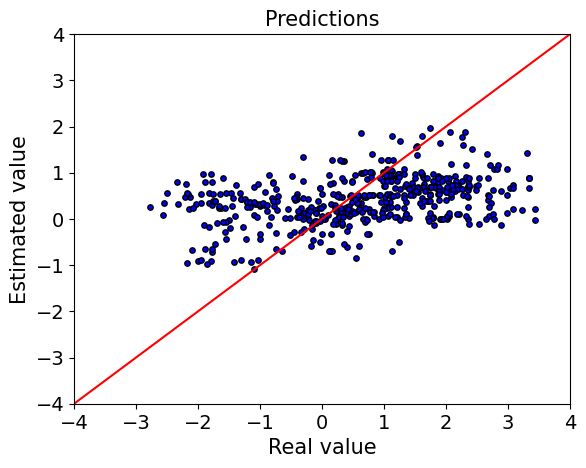

In [89]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

plt.scatter(val_Y,y_val_pred,c='blue', edgecolors='black',s=15)
    
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Real value', fontsize=15)
plt.ylabel('Estimated value', fontsize=15)
plt.title('Predictions', fontsize=15)
plt.axline((1, 1), slope=1, c='red')
plt.show()

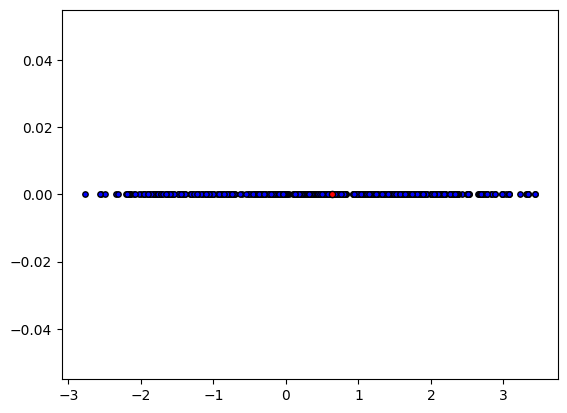

In [102]:
plt.scatter(val_Y, np.zeros_like(val_Y), c='blue', edgecolors='black',s=15)
plt.scatter(np.mean(val_Y), 0, c='red', edgecolors='black',s=20)

In [ ]:
importances = bst.get_score()

In [ ]:
print(len(data_train["ESM2"][1]))
print(len(data_train["difference_fp"][1]))
print(len(data_train["MACCS FP"][1]))

1280
2048
4096
167


In [ ]:
importances

{'f1': 14.0,
 'f2': 2.0,
 'f3': 1.0,
 'f5': 1.0,
 'f6': 4.0,
 'f7': 11.0,
 'f8': 1.0,
 'f9': 7.0,
 'f10': 2.0,
 'f11': 4.0,
 'f12': 1.0,
 'f16': 2.0,
 'f19': 2.0,
 'f20': 5.0,
 'f24': 2.0,
 'f25': 1.0,
 'f26': 2.0,
 'f28': 3.0,
 'f29': 1.0,
 'f30': 1.0,
 'f34': 1.0,
 'f35': 1.0,
 'f36': 4.0,
 'f42': 4.0,
 'f54': 4.0,
 'f55': 1.0,
 'f59': 1.0,
 'f62': 1.0,
 'f65': 3.0,
 'f70': 1.0,
 'f71': 1.0,
 'f74': 2.0,
 'f77': 1.0,
 'f85': 2.0,
 'f86': 1.0,
 'f87': 1.0,
 'f89': 1.0,
 'f90': 3.0,
 'f107': 7.0,
 'f118': 4.0,
 'f125': 1.0,
 'f126': 2.0,
 'f131': 5.0,
 'f132': 1.0,
 'f147': 3.0,
 'f150': 1.0,
 'f151': 2.0,
 'f153': 1.0,
 'f161': 4.0,
 'f162': 2.0,
 'f168': 1.0,
 'f179': 1.0,
 'f181': 1.0,
 'f195': 1.0,
 'f198': 1.0,
 'f200': 1.0,
 'f208': 2.0,
 'f214': 1.0,
 'f218': 2.0,
 'f219': 1.0,
 'f220': 1.0,
 'f228': 1.0,
 'f235': 1.0,
 'f237': 3.0,
 'f238': 1.0,
 'f240': 1.0,
 'f248': 4.0,
 'f253': 1.0,
 'f254': 1.0,
 'f255': 1.0,
 'f277': 1.0,
 'f281': 4.0,
 'f290': 2.0,
 'f292': 1.0,
 'f303':

(array([332.,  18.,   7.,   6.,   6.,   6.,   3.,   4.,   4.,   0.,   1.,
          1.,   1.,   1.,   2.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.,   0.,   0.,   0.,   0.,   1.]),
 array([4.00000000e-03, 3.95039200e+01, 7.90038400e+01, 1.18503760e+02,
        1.58003680e+02, 1.97503600e+02, 2.37003520e+02, 2.76503440e+02,
        3.16003360e+02, 3.55503280e+02, 3.95003200e+02, 4.34503120e+02,
        4.74003040e+02, 5.13502960e+02, 5.53002880e+02, 5.92502800e+02,
        6.32002720e+02, 6.71502640e+02, 7.11002560e+02, 7.50502480e+02,
        7.90002400e+02, 8.29502320e+02, 8.69002240e+02, 9.08502160e+02,
        9.48002080e+02, 9.87502000e+02, 1.02700192e+03, 1.06650184e+03,
        1.10600176e+03, 1.14550168e+03, 1.18500160e+03, 1.22450152e+03,
        1.26400144e+03, 1.30350136e+03, 1.34300128e+03, 1.38250120e+03,
        1.

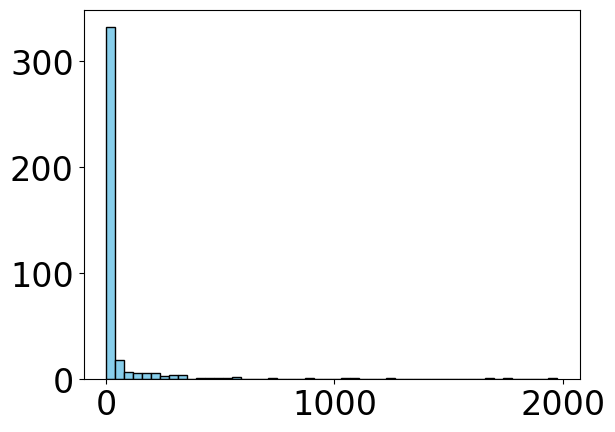

In [143]:
plt.hist([10**x for x in data_combined["log10_kcat"]], bins=50, color='skyblue', edgecolor='black')

(array([380.,  46.,  18.,  11.,  11.,   3.,   2.,   1.,   6.,   3.,   4.,
          0.,   2.,   2.,   0.,   0.,   0.,   3.,   0.,   1.,   0.,   3.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   2.,   2.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   1.]),
 array([1.66666700e-03, 5.53349733e+01, 1.10668280e+02, 1.66001587e+02,
        2.21334893e+02, 2.76668200e+02, 3.32001507e+02, 3.87334813e+02,
        4.42668120e+02, 4.98001427e+02, 5.53334733e+02, 6.08668040e+02,
        6.64001347e+02, 7.19334653e+02, 7.74667960e+02, 8.30001267e+02,
        8.85334573e+02, 9.40667880e+02, 9.96001187e+02, 1.05133449e+03,
        1.10666780e+03, 1.16200111e+03, 1.21733441e+03, 1.27266772e+03,
        1.32800103e+03, 1.38333433e+03, 1.43866764e+03, 1.49400095e+03,
        1.54933425e+03, 1.60466756e+03, 1.66000087e+03, 1.71533417e+03,
        1.77066748e+03, 1.82600079e+03, 1.88133409e+03, 1.93666740e+03,
        1.

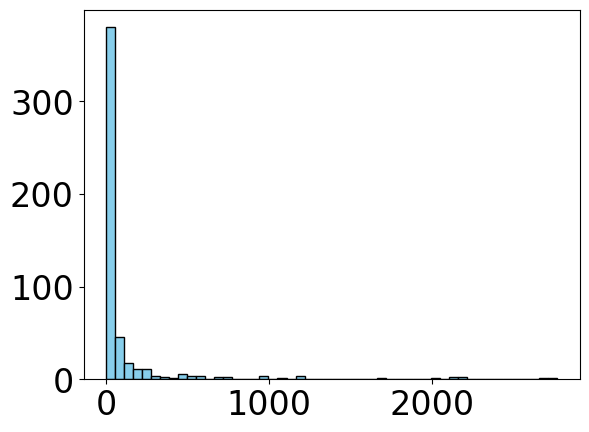

In [145]:
plt.hist([10**x for x in data_val["log10_kcat"]], bins=50, color='skyblue', edgecolor='black')

In [56]:
data_combined = pd.concat([data_train, data_test],ignore_index=True)


In [32]:
def calculate_identity_ignore_gaps(seq1, seq2):
    identical_residues = sum([1 for x, y in zip(seq1, seq2) if x == y and x != "-"])
    pid = identical_residues / sum([1 for x in seq1 if x != "-"]) 
    return pid

from Bio import Align
from Bio.Align import substitution_matrices

data_val["max_identity"] = np.nan

aligner=Align.PairwiseAligner()
aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")
aligner.mode = "global"
aligner.extend_gap_score = -0.5
aligner.open_gap_score = -10

for i in data_val.index:
    identities = []
    for j in data_combined.index:
        seq1 = str(data_val["Sequence"][i])
        seq2 = str(data_combined["Sequence"][j])
        if 'U' in seq1:
            seq1 = seq1.replace('U', 'C')
        if 'U' in seq2:
            seq2 = seq2.replace('U', 'C')
        alignments = aligner.align(seq1, seq2)
        identities.append(calculate_identity_ignore_gaps(alignments[0][0], alignments[0][1]))
    data_val["max_identity"][i] = max(identities)

In [34]:
data_val["max_identity"] = data_val["max_identity"]*100

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


327
0-40% -0.08483464279753772 396.3189975798378
172
40-80% -0.18120129339604407 172.57496598015445
6
80-99% 0.1276410878374188 5.824646511990595


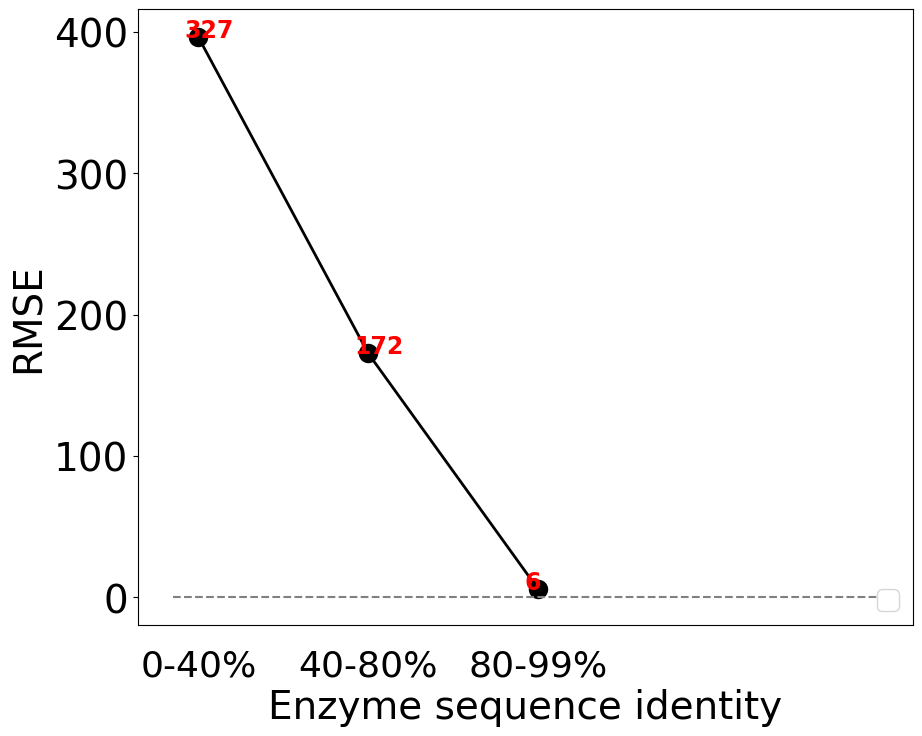

In [45]:
import matplotlib.pyplot as plt
import sklearn.metrics as sk
import math

fig, ax = plt.subplots(figsize= (10,8))
plt.rcParams.update({'font.size': 28})

splits = ["0-40%", "40-80%", "80-99%"]
lower_bounds = [0,40,80]
upper_bounds = [40,80,99]

points1 = []
points2 = []
n_points1, n_points2 = [], []

for i, split in enumerate(splits):

    lb, ub = lower_bounds[i], upper_bounds[i]
    
    help_df = data_val.loc[data_val["max_identity"]>= lb].loc[data_val["max_identity"]<= ub]
    y_true = np.array([10**x for x in help_df["log10_kcat"]])
    y_pred = np.array([10**x for x in help_df["Estimate kcat"]])
    n_kcat = len(y_pred)
    R2 =  sk.r2_score(y_true, y_pred)
    abs_error = abs(y_true - y_pred)
    rmse = math.sqrt(np.mean(abs(y_true - y_pred)**2))
    print(len(y_true))
    print(split, R2, rmse)
    points1.append(R2)
    points2.append(rmse)
    n_points1.append(n_kcat)


ticks2 = np.array(range(len(splits)))
labs = splits
ax.set_xticks(ticks2)
ax.set_xticklabels(labs,  y= -0.03, fontsize=26)
ax.tick_params(axis='x', length=0, rotation = 0)

# plt.ylim((-0.1,2.5))
# plt.xlim((-0.2, 3.2))
plt.legend(loc = "lower right", fontsize=20)
plt.ylabel('RMSE')
plt.xlabel('Enzyme sequence identity')
# ax.yaxis.set_label_coords(-0.15, 0.5)
# ax.xaxis.set_label_coords(0.5,-0.13)

plt.plot([-0.15,4], [0,0], color='grey', linestyle='dashed')


plt.plot([0,1,2], points2, c= "black", linewidth=2)

for i, split in enumerate(splits):
    points1.append(R2)
    
    if i ==0:
        plt.scatter(i, points2[i], c='black', marker="o", linewidths= 8)
        ax.annotate(n_points1[i], (i-0.08, points2[i]+0.08), fontsize=17, c= "red", weight = "bold")

    else:
        plt.scatter(i, points2[i], c='black', marker="o", linewidths= 8)
        ax.annotate(n_points1[i], (i-0.08, points2[i]+0.08), fontsize=17, c= "red", weight = "bold")
            
     
plt.savefig(join("..","..", "data", "sequence_identity.png"))
plt.show()

In [49]:
EC_kcat_pred =[[] for _ in range(6)]
EC_kcat =[[] for _ in range(6)]
for ind in data_val.index:
    try:
        EC = int(data_val["ECs"][ind][0][0])
        EC_kcat[EC-1].append(data_val["log10_kcat"][ind])
        EC_kcat_pred[EC-1].append(data_val["Estimate kcat"][ind])
    except IndexError:
        pass

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


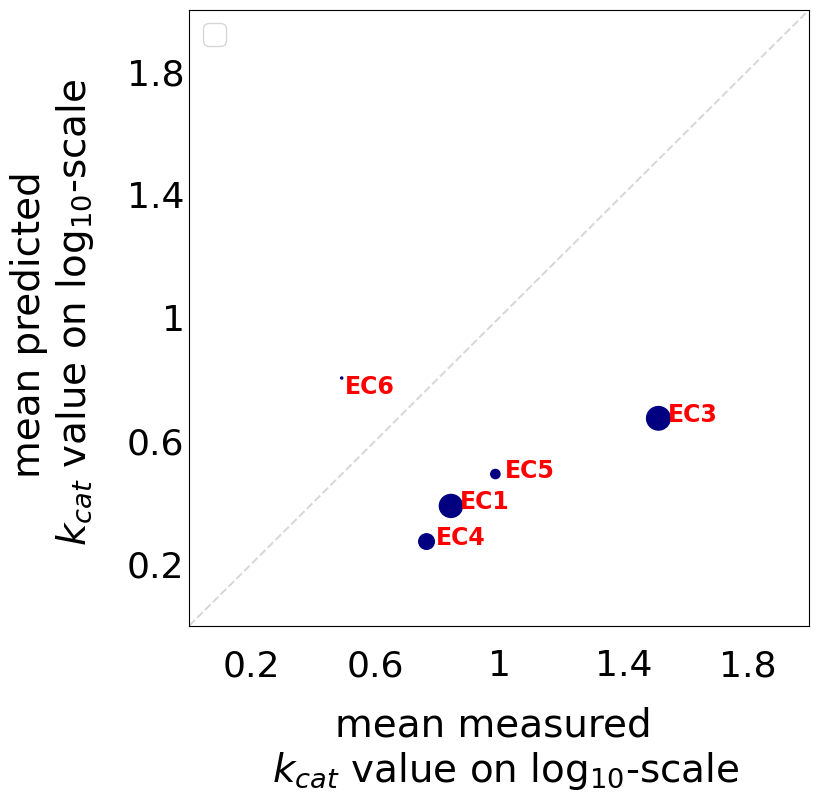

In [50]:
fig, ax = plt.subplots(figsize= (8,8))
plt.rcParams.update({'font.size': 28})

classes = [str(i) for i in range(1,7)]

for i in range(len(EC_kcat)):
    
    circle = plt.Circle((np.mean(EC_kcat[i]), np.mean(EC_kcat_pred[i]) ),
                        np.sqrt(len(EC_kcat_pred[i]))/300, color='navy', fill = True)
    ax.add_artist(circle)
    if i ==5:
        ax.annotate("EC"+ str(i+1), (np.mean(EC_kcat[i])+0.01, np.mean(EC_kcat_pred[i])-0.05), fontsize=17, c='red', weight = "bold")
    else:
        ax.annotate("EC"+ str(i+1), (np.mean(EC_kcat[i])+0.03, np.mean(EC_kcat_pred[i])-0.01), fontsize=17, c='red', weight = "bold")
    

ticks2 = [0.2, 0.6,1,1.4,1.8]
labs = ticks2
ax.set_xticks(ticks2)
ax.set_xticklabels(labs,  y= -0.03, fontsize=26)
ax.tick_params(axis='x', length=0, rotation = 0)

ax.set_yticks(ticks2)
ax.set_yticklabels(labs,  y= -0.03, fontsize=26)
ax.tick_params(axis='y', length=0, rotation = 0)

plt.ylim((0,2))
plt.xlim((0, 2))
plt.legend(loc = "upper left", fontsize=20)
plt.xlabel('mean measured \n $k_{cat}$ value on $\log_{10}$-scale')
plt.ylabel('mean predicted \n $k_{cat}$ value on $\log_{10}$-scale')
ax.yaxis.set_label_coords(-0.15, 0.5)
ax.xaxis.set_label_coords(0.5,-0.13)

plt.plot([0,2], [0,2], color='grey', alpha = 0.3, linestyle='dashed')
plt.savefig(join("..", "..", "data", "EC_classes_mean_kcat.png"))
plt.show()

In [132]:
import scipy

train_fps = [data_combined["difference_fp"][ind][:3276].reshape(1,-1).astype(int) for ind in data_combined.index]
test_fps = [data_val["difference_fp"][ind][:3276].reshape(1,-1).astype(int) for ind in data_val.index]

max_sim = []

for fp in test_fps:
    jaccard_sim = np.array([1 - scipy.spatial.distance.cdist(fp,train_fp, metric='jaccard')[0][0] for train_fp in train_fps])
    max_sim.append(np.max(jaccard_sim))
    
data_val["reaction_sim"] = max_sim

data_val["reaction_sim"]= (data_val["reaction_sim"] - np.min(data_val["reaction_sim"]))
data_val["reaction_sim"] = data_val["reaction_sim"]/np.max(data_val["reaction_sim"])

In [127]:
train_fps = [np.array(list(data_combined["MACCS FP"][ind])).reshape(1,-1) for ind in data_combined.index]
test_fps = [np.array(list(data_val["MACCS FP"][ind])).reshape(1,-1) for ind in data_val.index]

max_sim = []

for fp in test_fps:
    jaccard_sim = np.array([1 - scipy.spatial.distance.cdist(fp,train_fp, metric='jaccard')[0][0] for train_fp in train_fps])
    max_sim.append(np.max(jaccard_sim))
    
data_val["substrate_sim"] = max_sim

data_val["substrate_sim"]= (data_val["substrate_sim"] - np.min(data_val["substrate_sim"]))
data_val["substrate_sim"] = data_val["substrate_sim"]/np.max(data_val["substrate_sim"])

In [133]:
data_val["global_sim"] = (data_val["max_identity"]/100)*data_val["reaction_sim"]*data_val["substrate_sim"]

In [134]:
data_val

,Reaction ID,Sequence ID,Temperature,pH,Type,Main substrate,kcat_values,Uniprot IDs,ECs,Organisms,...,ESM2,Sequence,difference_fp,structural_fp,log10_kcat,Estimate kcat,max_identity,reaction_sim,global_sim,substrate_sim
0,Reaction_0,Sequence_0,28.0,6.5,1,0000000000000000000001000010010000000010000101...,[0.3],[Q15GI3],[1],[Petunia hybrida],...,"[-0.032205846, -0.031796537, -0.051493276, 0.0...",MTTGKGKILILGATGYLGKYMVKASISLGHPTYAYVMPLKKNSDDS...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1100111100000001001000110110010001001111111100...,-0.522879,0.011753,33.746130,0.700112,0.236261,1.000000
1,Reaction_1,Sequence_1,28.0,6.5,1,0000000000000000000001000010010000000010000101...,[0.7],[Q15GI4],[1],[Ocimum basilicum],...,"[-0.016749386, -0.048214775, -0.049711384, 0.0...",MEENGMKSKILIFGGTGYIGNHMVKGSLKLGHPTYVFTRPNSSKTT...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1100111100000001001000110110010001001111111100...,-0.154902,-0.219674,35.031847,0.650258,0.227798,1.000000
2,Reaction_2,Sequence_2,30.0,5.0,1,0000000000000000000001000010010000000010000101...,[1.01],[A7DY56],[1.1.1],[Cochlearia officinalis],...,"[-0.0007728094, -0.061243154, 0.041369718, 0.0...",MANLRESSRDKSRWSLEGMTALVTGGSKGIGEAVVEELAMLGARVH...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1100111100000001001000110110010001001111111100...,0.004321,0.064235,79.853480,1.000000,0.798535,1.000000
3,Reaction_3,Sequence_2,30.0,5.0,1,0000000000000000000001000010010000000010000101...,[11.8],[A7DY56],[1.1.1],[Cochlearia officinalis],...,"[-0.0007728094, -0.061243154, 0.041369718, 0.0...",MANLRESSRDKSRWSLEGMTALVTGGSKGIGEAVVEELAMLGARVH...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1100111100000001001000110110010001001111111100...,1.071882,0.064235,79.853480,0.890952,0.711456,1.000000
4,Reaction_5,Sequence_2,30.0,9.5,1,0000000000000000000000000000000000000000000000...,[0.45],[A7DY56],[1.1.1],[Cochlearia officinalis],...,"[-0.0007728094, -0.061243154, 0.041369718, 0.0...",MANLRESSRDKSRWSLEGMTALVTGGSKGIGEAVVEELAMLGARVH...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1100111100000001001000110110010001001101111100...,-0.346787,0.231783,79.853480,0.765643,0.349367,0.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,Reaction_502,Sequence_511,25.0,7.5,2,0000000000000000000000000000000000000000000000...,[4.733333],[P28012],[5.5.1.6],[Medicago sativa],...,"[-0.0048498944, -0.044011533, -0.026983105, 0....",MAASITAITVENLEYPAVVTSPVTGKSYFLGGAGERGLTIEGNFIK...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1100000000000100000000000000000001000000001000...,0.675167,0.508538,38.738739,0.080016,0.019373,0.625000
500,Reaction_502,Sequence_512,25.0,7.5,2,0000000000000000000000000000000000000000000000...,[2.933333],[P28012],[5.5.1.6],[Medicago sativa],...,"[-0.005215733, -0.04523683, -0.02394097, 0.025...",MAASITAITVENLEYPAVVTSPVTGKSYFLGGAGERGLTIEGNFIK...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1100000000000100000000000000000001000000001000...,0.467361,0.527905,38.738739,0.080016,0.019373,0.625000
501,Reaction_503,Sequence_511,25.0,7.5,2,0000000000000000000000000000000000000000000000...,[5.716667],[P28012],[5.5.1.6],[Medicago sativa],...,"[-0.0048498944, -0.044011533, -0.026983105, 0....",MAASITAITVENLEYPAVVTSPVTGKSYFLGGAGERGLTIEGNFIK...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1100000000000100000000000000000001000000001000...,0.757143,0.508538,38.738739,0.083133,0.022035,0.684211
502,Reaction_503,Sequence_512,25.0,7.5,2,0000000000000000000000000000000000000000000000...,[3.75],[P28012],[5.5.1.6],[Medicago sativa],...,"[-0.005215733, -0.04523683, -0.02394097, 0.025...",MAASITAITVENLEYPAVVTSPVTGKSYFLGGAGERGLTIEGNFIK...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1100000000000100000000000000000001000000001000...,0.574031,0.527905,38.738739,0.083133,0.022035,0.684211


In [138]:
data_val.describe()

,Type,log10_kcat,Estimate kcat,max_identity,reaction_sim,global_sim,substrate_sim
count,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000
mean,1.206349,0.632344,0.416711,40.599339,0.454742,0.179950,0.721717
std,0.405086,1.393167,0.511257,15.265933,0.355490,0.228283,0.295715
min,1.000000,-2.778151,-1.086050,20.910973,0.000000,0.000000,0.000000
25%,1.000000,-0.301030,0.104034,30.751708,0.105866,0.022111,0.500000
50%,1.000000,0.767525,0.431019,34.796238,0.355215,0.072142,0.868396
75%,1.000000,1.737985,0.735648,43.811395,0.819866,0.236475,1.000000
max,2.000000,3.441957,1.976682,90.476190,1.000000,0.904762,1.000000


0.0 - 0.4 -5655.455363073545 0.13251247573826913 367.5966874149235 415
0.4 - 0.8 -10.119373287924091 0.3025741381068431 67.57371823630834 84
0.8 - 1 -3.0004569232030516 0.5301545274053268 5.7352947263397205 5


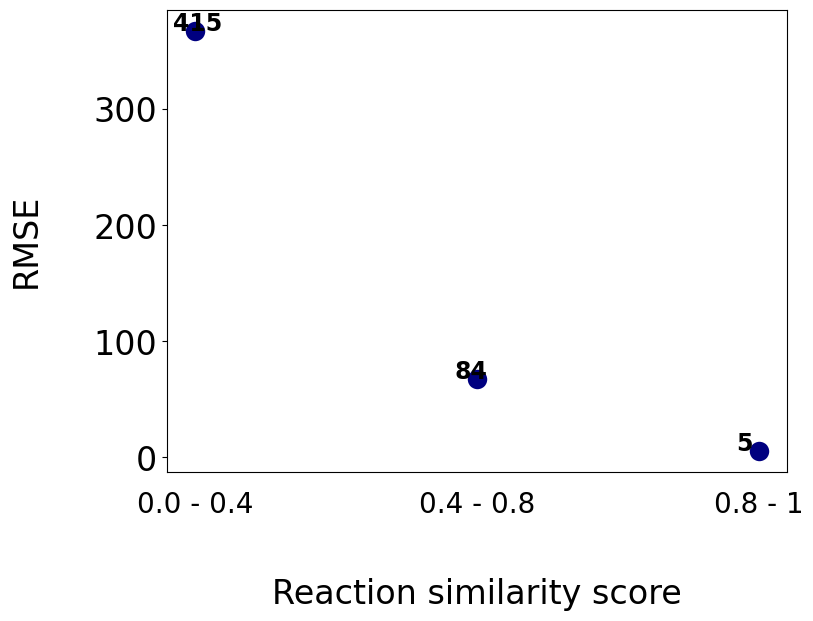

In [137]:
import matplotlib.pyplot as plt
import math
import scipy as sci
help_df = data_val

sim_bins_lb = [0.0, 0.4, 0.8]
sim_bins_ub = [0.4, 0.8, 1]
r2_scores, n_points, pearson_r, rmse = [], [], [], []
for i in range(len(sim_bins_lb)):
    help_df2 = help_df.loc[help_df["global_sim"] <= sim_bins_ub[i]].loc[help_df["global_sim"] >= sim_bins_lb[i]]
    pred = np.array([10**x for x in help_df2["log10_kcat"]])
    true = np.array([10**x for x in help_df2["Estimate kcat"]])
    r2_scores.append(sk.r2_score(true, pred))
    pearson_r.append(sci.stats.pearsonr(true, pred)[0])
    rmse.append(math.sqrt(np.mean(abs(true - pred)**2)))
    n_points.append(len(pred))
    print("%s - %s" % (sim_bins_lb[i], sim_bins_ub[i]), r2_scores[-1], pearson_r[-1], rmse[-1], len(pred))
    

plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(figsize= (8,6))

for i in range(len(sim_bins_lb)):    
    plt.scatter(i, rmse[i], c='navy', marker="o", linewidths= 8)
    ax.annotate(n_points[i], (i-0.08, rmse[i]+0.05), fontsize=17, c= "black", weight = "bold")

    
plt.xlabel('Reaction similarity score')
plt.ylabel('RMSE')
ax.yaxis.set_label_coords(-0.2, 0.5)
ax.xaxis.set_label_coords(0.5,-0.23)

ticks2 = np.array(range(len(sim_bins_lb)))
labs = ["%s - %s" % (sim_bins_lb[i], sim_bins_ub[i]) for i in range(len(sim_bins_lb))]
ax.set_xticks(ticks2)
ax.set_xticklabels(labs,  y= -0.03, fontsize=20)
ax.tick_params(axis='x', length=0, rotation = 0)

# plt.ylim((0.5,2))
#plt.xlim((-0.5, 3.2))

# plt.plot([-0.49, 4], [0,0], color='grey', linestyle='dashed')
#plt.savefig(join("..","..", "data", "figures", "Reaction_Similarity_Score.eps"))
plt.show()